In [105]:
%matplotlib inline

import os, sys, time
import pickle as pkl
import numpy as np
import sklearn as sk

from sklearn.linear_model import LogisticRegression as LR

import matplotlib.pyplot as plt
import seaborn as sns

#from scipy.optimize import minimize
#from scipy.misc import logsumexp

In [2]:
data_dir = 'data'
faotm = os.path.join(data_dir, 'aotm-2011/aotm-2011-subset.pkl')
fmap  = os.path.join(data_dir, 'aotm-2011/map_song_track.pkl')
ftag  = os.path.join(data_dir, 'msd/msd_tagtraum_cd2c.cls')

## Data loading

Load playlists.

In [3]:
playlists = pkl.load(open(faotm, 'rb'))

In [4]:
print(len(playlists))

241


In [5]:
playlists[0]

{'category': 'Road Trip',
 'filtered_lists': [['SOYXQBU12CF5F88FAA',
   'SOYDNDN12A58A77663',
   'SOOLDQA12A6D4F9370',
   'SOHCPBA12AB018377B',
   'SOHGHSU12AB0186C5F',
   'SOFRCHU12A8C13F96B',
   'SONHAWL12A6310F260',
   'SOXRJWV12A8C13DE1D',
   'SOUPNVN12AB018B0B4',
   'SOEYNQL12A67ADE655',
   'SOZTMFN12A58A7DCEE',
   'SORDYVO12A8C141A40']],
 'mix_id': 113009,
 'playlist': [[['Simon & Garfunkel', 'America'], 'SOYXQBU12CF5F88FAA'],
  [['Marc Cohn', 'Walking In Memphis'], 'SOYDNDN12A58A77663'],
  [['Matt Pond PA', 'Lily Two'], 'SOOLDQA12A6D4F9370'],
  [['Grateful Dead', 'Tennessee Jed'], 'SOHCPBA12AB018377B'],
  [['Braid', 'Killing a Camera'], 'SOHGHSU12AB0186C5F'],
  [['Johnny Cash', 'Hey Porter'], 'SOFRCHU12A8C13F96B'],
  [["Marcy's Playground", 'Memphis'], 'SONHAWL12A6310F260'],
  [['Whiskeytown', 'Lo-Fi Tennessee Mountain Angel'], 'SOXRJWV12A8C13DE1D'],
  [['Something Corporate', 'I Woke Up in a Car'], 'SOUPNVN12AB018B0B4'],
  [['The Boy Least Likely To',
    "I'm Glad I Hitched My

Load `song_id` --> `track_id` mapping.

In [6]:
song2TrackID = pkl.load(open(fmap, 'rb'))

In [7]:
{ k : song2TrackID[k] for k in list(song2TrackID.keys())[:10] }

{'SOARSZT12A8C13A21A': ['TRYNVIL128F4296300'],
 'SOBQQSF12A8C13AF5A': ['TRHMUGZ128F428CA6D'],
 'SOBSAAB12A8AE46253': ['TRGVYBU128F425B737'],
 'SOCRAIA12AF729FD40': ['TRQARLV12903CD6D5A'],
 'SONCQKA12A6D4F825E': ['TRYETLN128F9331376'],
 'SOPRZQA12A58A7A112': ['TRDFPKD128E0781B20'],
 'SOQNVTB12AB01869AB': ['TRQNNIP128F933122C'],
 'SOSCERR12A58A7E236': ['TRQUSPL128F4265001'],
 'SOSKEGE12A8C134A86': ['TRPVGFU128F426A577'],
 'SOWCEMD12A8C137121': ['TREELGP128F428748B']}

Load song tags.

In [9]:
track2Tags = dict()

In [10]:
with open(ftag) as f:
    for line in f:
        if line[0] == '#': continue
        tid, tag = line.strip().split('\t')
        #print(tid, tag)
        track2Tags[tid] = tag

In [11]:
len(track2Tags)

191401

In [12]:
{ k : track2Tags[k] for k in list(track2Tags.keys())[:10] }

{'TRAXJZV12903CEB4DB': 'Electronic',
 'TREUOZE128F422F626': 'Punk',
 'TRFJWRC128F4271F19': 'Rock',
 'TRFXMZW128F9303187': 'Rap',
 'TRQHYFI128F4291FE1': 'Reggae',
 'TRVXELZ128F4252E00': 'Folk',
 'TRWIHPB128F428AB14': 'Rap',
 'TRXOCHW128F4244C2E': 'Metal',
 'TRZKPFJ128F9349927': 'Rock',
 'TRZZQLC12903CE2FEC': 'Country'}

## Data cleaning

Use the subset of playlist that each song in it has a tag.

In [13]:
subset_ix = []

In [14]:
# for ix in range(len(playlists)):
#     sids = playlists[ix]['filtered_lists'][0]
#     proper = True
#     for sid in sids:
#         tids = map_song_track[sid]
#         flag = [tid in tags for tid in tids]
#         if not np.any(flag):
#             proper = False
#             break
#     if proper: subset_ix.append(ix)

In [16]:
for ix in range(len(playlists)):
    # the list of song IDs in the playlist
    songIDs = playlists[ix]['filtered_lists'][0]

    # seed song
    seedSongID   = songIDs[0]
    seedTrackIDs = song2TrackID[seedSongID]
    
    # make sure that at least one track for the song has a corresponding tag
    flag = [ (trackID in track2Tags) for trackID in seedTrackIDs]
    if not np.any(flag):
        continue

    subset_ix.append(ix)

In [17]:
len(subset_ix)

130

In [18]:
playlists_subset = [playlists[ix] for ix in subset_ix]

## Tag assignment

We want to find a list of tags for each track.

In [69]:
song_set = sorted([songID for p in playlists_subset for songID in p['filtered_lists'][0]])

In [32]:
len(song_set)

1186

In [33]:
print(song_set[:10])

['SOAAFAC12A67ADF7EB', 'SOAAJWZ12A67AE16FB', 'SOABLRM12A6701F091', 'SOADISH12AB018DFAC', 'SOADISH12AB018DFAC', 'SOADISH12AB018DFAC', 'SOADISH12AB018DFAC', 'SOADQHJ12AF729D75C', 'SOAGENT12A8C1363D1', 'SOAGGRW12A6D4F920E']


## One-hot tag encoding

Indicator of tags: `tag` --> `tag index` mapping.

In [38]:
# the set of unique tags
tag_set = list(set(track2Tags.values()))

In [39]:
len(tag_set)

15

In [40]:
tag_indicator = { tag: ix for ix, tag in enumerate(sorted(tag_set)) }

In [41]:
tag_indicator

{'Blues': 0,
 'Country': 1,
 'Electronic': 2,
 'Folk': 3,
 'Jazz': 4,
 'Latin': 5,
 'Metal': 6,
 'New Age': 7,
 'Pop': 8,
 'Punk': 9,
 'Rap': 10,
 'Reggae': 11,
 'RnB': 12,
 'Rock': 13,
 'World': 14}

## Feature extraction

Build features (1-hot encoding of tag) for a song given its `song_id`.

In [71]:
def gen_features(song_id):
    """
        Generate one-hot feature vector for a given song ID
    """

    features = np.zeros(len(tag_set), dtype = np.float)
    trackIDs = song2TrackID[song_id]

    cnt = 0
    for trackID in trackIDs:
        if trackID in track2Tags:
            cnt += 1
            tag = track2Tags[trackID]
            tag_ix = tag_indicator[tag]
            features[tag_ix] = 1

    # must have at least one tag for the song, else useless
    assert(cnt >= 1)

    return features

In [72]:
def gen_feature_map(song_id, seed):
    """
        Generate feature mapping for a given (label, query) pair
    """
    
    #return gen_features(song_id) - gen_features(seed)  # feature map
    return gen_features(seed)  # feature map

In [110]:
def gen_training_set(label_ix, playlists = playlists_subset):
    """
        Create the labelled dataset for a given song index
        
        Input:
            - label_ix: song index, number in { 0, ..., # songs }
            - playlists: which playlists to create features for
            
        Output:
            - (Feature, Label) pair (X, y), with # num playlists rows
              X comprises the features for each seed song and the given song
              y comprises the indicator of whether the given song is present in the respective playlist
    """

    assert(label_ix >= 0)
    assert(label_ix < len(song_set))

    N = len(playlists)
    d = len(tag_set)

    X = np.zeros((N, d), dtype = np.float)
    y = np.zeros(N, dtype = np.float)
    
    whichSong = song_set[label_ix]
    
    for i in range(len(playlists)):
        playlist = playlists[i]['filtered_lists'][0]
        seed     = playlist[0]

        X[i,:] = gen_feature_map(whichSong, seed)
        y[i]   = int(whichSong in playlist)

    return X, y

In [111]:
gen_feature_map(song_set[42], song_set[0])

array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.])

In [112]:
ix = 50

In [113]:
track2Tags[song2TrackID[song_set[ix]][0]]

'Rock'

## Training

Train a logistic regression model for each label.

In [114]:
classifiers = [LR(class_weight='balanced') for i in range(len(song_set))]

In [143]:
allPreds  = [ ]
allTruths = [ ]

for label_ix in range(len(song_set)):
    X, y = gen_training_set(label_ix)
    
    # by fixing random seed, the same playlists will be in the test set each time
    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size = 0.33, random_state = 42)    
    
    if np.max(y_train) == 0.0 or np.max(y_test) == 0.0:
        continue

    classifiers[label_ix].fit(X_train, y_train)
    
    allPreds.append(classifiers[label_ix].decision_function(X_test))
    allTruths.append(y_test)    

#     print(classifiers[label_ix].coef_)
#     print(classifiers[label_ix].intercept_)    

In [144]:
allPreds = np.array(allPreds).T
allTruths = np.array(allTruths).T

print(allPreds.shape)
print(allTruths.shape)

(43, 273)
(43, 273)


Average AUC: 0.6047


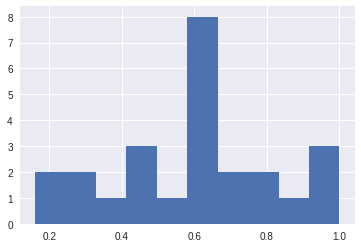

In [147]:
aucs = [ ]
for i in range(0,allPreds.shape[0]):
    pred  = allPreds[i,:]
    truth = allTruths[i,:]
    
    if np.max(truth) == 0.0:
        continue
    
    aucs.append(sk.metrics.roc_auc_score(truth, pred))
    
print('Average AUC: %1.4f' % np.mean(aucs))
plt.hist(aucs, bins = 10);